In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep


hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


In [2]:
# This block is the same as 1_dataset.ipynb

datasets = {
    "train": "/eos/user/m/mgarciam/datasets_tracking/Pythia/Zcard/reco_Zcard_1.root",
    "test": "/eos/user/m/mgarciam/datasets_tracking/Pythia/Zcard/reco_Zcard_1.root"
}

class Args:
    def __init__(self, datasets):
        self.data_train = [datasets]
        self.data_val = [datasets]
        #self.data_train = files_train
        self.data_config = '/afs/cern.ch/work/m/mgarciam/private/mlpf/config_files/config_tracking.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 1
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = {key: Args(value) for key, value in datasets.items()}

datas = {}
files_dict = {}
for key in datasets:
    train_range = (0, args[key].train_val_split)
    train_file_dict, train_files = to_filelist(args[key], 'train')
    train_data = SimpleIterDataset(train_file_dict, args[key].data_config, for_training=True,
                                   extra_selection=args[key].extra_selection,
                                   remake_weights=True,
                                   load_range_and_fraction=(train_range, args[key].data_fraction),
                                   file_fraction=args[key].file_fraction,
                                   fetch_by_files=args[key].fetch_by_files,
                                   fetch_step=args[key].fetch_step,
                                   infinity_mode=False,
                                   in_memory=args[key].in_memory,
                                   async_load=False,
                                   name='train')
    datas[key] = train_data
    files_dict[key] = train_files

['/eos/user/m/mgarciam/datasets_tracking/Pythia/Zcard/reco_Zcard_1.root']
['/eos/user/m/mgarciam/datasets_tracking/Pythia/Zcard/reco_Zcard_1.root']


In [3]:
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

In [9]:
# iterators = {key: iter(val) for key, val in datas.items()}

from src.dataset.functions_graph import graph_batch_func

train_loaders = {key: DataLoader(datas[key], batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args[key].num_workers, int(len(files_dict[key]) * args[key].file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args[key].num_workers > 0 and args[key].steps_per_epoch is not None) for key in args}

iterators = {key: iter(item) for key,item in train_loaders.items()}

=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


In [42]:
itera = iter(train_loaders["train"])

=== Restarting DataIter train, seed=None ===


In [43]:
g, yy = next(itera)

/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps/lib/python3.10/site-packages/dgl/heterograph.py:92: DGLWarning:

Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.



In [69]:
xyz = g.ndata["pos_hits_xyz"]
x = xyz[:,0]
y = xyz[:,1]
u = x/ (torch.square(x)+torch.square(y))
v = y/ (torch.square(x)+torch.square(y))
uvz = torch.cat((u.view(-1,1),v.view(-1,1),xyz[:,2].view(-1,1)), dim=1)

In [87]:
cart = uvz[:,0:2]
rho = torch.norm(cart, p=2, dim=-1).view(-1, 1)
from math import pi as PI
theta = torch.atan2(cart[:, 1], cart[:, 0]).view(-1, 1)
theta = theta + (theta < 0).type_as(theta) * (2 * PI)
rho = rho / (rho.max() )
# theta = theta / (2 * PI)

polar = torch.cat([rho, theta], dim=-1)

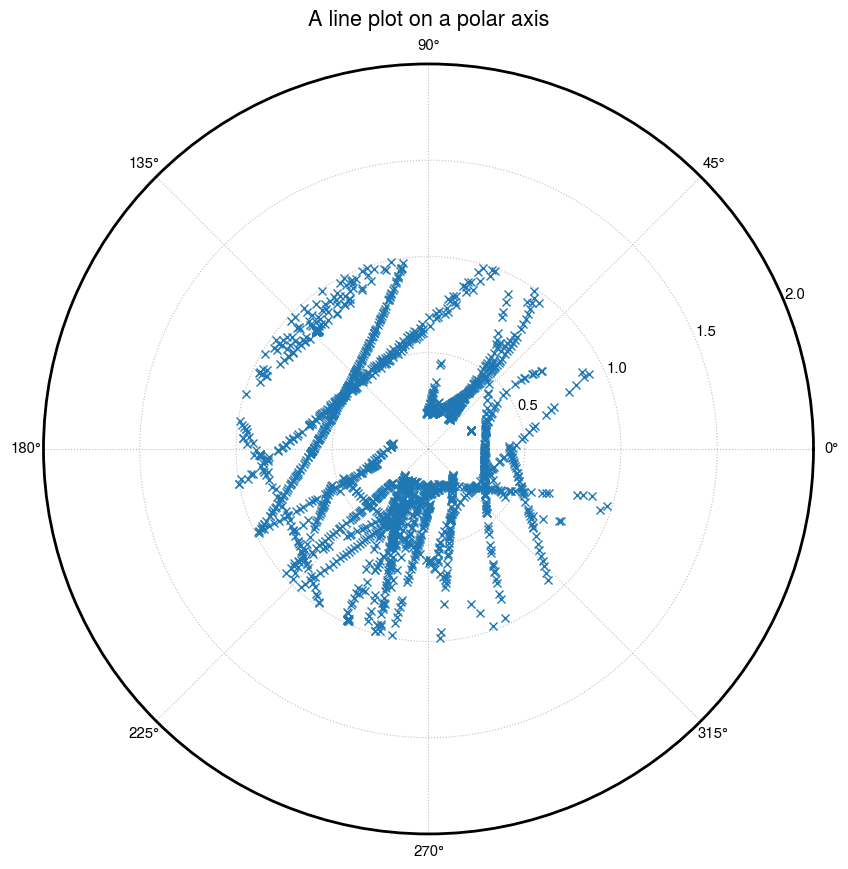

In [88]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, rho, 'x')
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

In [47]:
from torch_scatter import scatter_add, scatter_sum
scatter_add(torch.ones_like(g.ndata["particle_number"]), g.ndata["particle_number"].long())

tensor([  0.,  41.,  34.,  44.,  60.,  32.,  52.,  27.,  65.,  34.,  37.,  35.,
         63.,  51.,  31.,  49.,  67.,  54.,  42.,  37.,  20.,  23.,  63.,  25.,
        280.,  65.,  73., 217.,  29.,  79.,   3., 123.,  55., 136., 159.])

In [72]:
from src.logger.plotting_tools import shuffle_truth_colors
import pandas as pd
import plotly.express as px
tidx = g.ndata["particle_number"].view(-1,1)
X = uvz
Edep = torch.ones_like(xyz)[:,0]*0.005
data = {
    "X": X[:, 0].view(-1, 1).detach().cpu().numpy(),
    "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
    "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
    "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
    "features": Edep.view(-1, 1).detach().cpu().numpy(),
}
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
# rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size = "features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))



In [ ]:
from src.logger.plotting_tools import shuffle_truth_colors
import pandas as pd
import plotly.express as px
tidx = g.ndata["particle_number"].view(-1,1)
X = xyz
Edep = torch.ones_like(xyz)[:,0]*0.2
data = {
    "X": X[:, 0].view(-1, 1).detach().cpu().numpy(),
    "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
    "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
    "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
    "features": Edep.view(-1, 1).detach().cpu().numpy(),
}
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
# rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size = "features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to 5 (or any other range you prefer)
x_values = np.linspace(0, 5, 100)

# Calculate corresponding y values for exp(-x)
y_values = np.exp(-x_values)

# Plot the function
plt.plot(x_values, y_values, label='exp(-x)')
plt.title('Plot of exp(-x) for x > 0')
plt.xlabel('x')
plt.ylabel('exp(-x)')
plt.legend()
plt.grid(True)
plt.show()